In [ ]:
import numpy as np
import pandas as pd
import pylab as plt
import random as rd

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.util import minibatch, compounding
from nltk.stem.porter import *  

import re
import urllib.request
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_columns = None
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

nlp = spacy.load("en_core_web_md")

from spacy import displacy
import df_helper as dfh

from sklearn.utils.random import sample_without_replacement
import importlib

In [ ]:
from sklearn.base import TransformerMixin


from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier,AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn.metrics import make_scorer, accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix

import sklearn.metrics as met
from sklearn.metrics import precision_recall_curve, roc_curve, auc, matthews_corrcoef
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, average_precision_score, auc, \
    accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, classification_report, \
    brier_score_loss, roc_auc_score

from scipy.stats import randint as sp_randint , uniform
import eli5

## 3. Word embedding approach

[Word embedding](https://en.wikipedia.org/wiki/Word_embedding) map words to vectors of fixed dimensionality (typically in the range of hundreds). The basic idea is to map similar words into similar vectors, so that relationship between words are mapped into geometrical relationships.

Advantages of word embedding models are:
* ability to deal with synonyms and misspelling
* some insight into the meaning of concepts


In [52]:
def embedding_tokenizer(message):
    message=re.sub("[#@$'!*+%\".()!,]?;",'',message).replace('','').replace('-','')
    message=' '.join(message.split())
    doc=nlp(message)
    words=[]

    remove_ent=[]
    for ent in doc.ents:
        if ent.label_ in ['GPE','LOC','NORP','FAC','ORG','LANGUAGE']:
            remove_ent.append(ent.text)
            
    # remove punctuation etc
    for token in doc:
        if ( (~token.is_stop)   & (token.pos_!='NUM') & (token.pos_!='PUNCT') & (token.pos_!='SYM') &
           ~(token.text in (remove_ent)) & (len(token.text)>1) & (token.has_vector) ):
            words.append(token.text)
    return(words)

In [53]:
food_message1= df.loc[df.food==1,'message'].iloc[0] 
food_message2= df.loc[df.food==1,'message'].iloc[5] 
other_message= df.loc[df.food==0,'message'].iloc[6] 

t1=nlp(" ".join(embedding_tokenizer(food_message1)))
t2=nlp(" ".join(embedding_tokenizer(food_message2)))
t3=nlp(" ".join(embedding_tokenizer(other_message)))


print('1: ',food_message1)
print('2: ',food_message2)
print('3: ',other_message)

print( )

print('message 1-2 similarity: ', t1.similarity(t2))
print()
print('message 1-3 similarity: ', t1.similarity(t3))
print('message 2-3 similarity: ', t2.similarity(t3))


1:  There's nothing to eat and water, we starving and thirsty.
2:  How can we get water and food in Fontamara 43 cite Tinante?
3:  I would like to receive the messages, thank you

message 1-2 similarity:  0.7056666438629938

message 1-3 similarity:  0.35251518688406175
message 2-3 similarity:  0.37734246809506683


In [71]:
train =pd.concat((X_train,Y_train),axis=1).values
test =pd.concat((X_test,Y_test),axis=1).values
valid =pd.concat((X_valid,Y_valid),axis=1).values


In [55]:
train[1]

array(['Is the Hurricane over or is it not over', 0], dtype=object)

In [68]:


def load_data(train_data,limit=0):
    """Load data"""
    # Partition off part of the train data for evaluation

    rd.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]
    
    return (texts, cats)

In [57]:
if "textcat" not in nlp.pipe_names:
    textcat = nlp.create_pipe(
        "textcat",
        config={
            "exclusive_classes": True,
            "architecture": "simple_cnn",
        }
    )
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe("textcat")
    

In [58]:
# nlp.remove_pipe("textcat")

In [69]:
textcat.add_label('POSITIVE')
textcat.add_label("NEGATIVE")

0

In [72]:
train_texts, train_cats = load_data(train)
dev_texts, dev_cats = load_data(test)
val_texts, val_cats = load_data(valid)


In [73]:
n_texts=1000

train_texts = train_texts[:n_texts]
train_cats = train_cats[:n_texts]

print(
        "Using {} examples ({} training, {} evaluation)".format(
            n_texts, len(train_texts), len(dev_texts)
        )
    )

Using 1000 examples (1000 training, 2629 evaluation)


In [76]:
train_texts[0], train_cats[0]

('Weather update - a cold front from Cuba that could pass over Haiti',
 {'POSITIVE': False, 'NEGATIVE': True})

In [77]:
def evaluate(tokenizer, textcat, texts, cats):
    
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}


In [78]:
train_data = list(zip(train_texts, [{"cats": cats} for cats in train_cats]))

# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "textcat"]



In [80]:
init_tok2vec=None


n_iter=20

with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()

    print("Training the model...")
    print("{:^5}\t{:^5}\t{:^5}\t{:^5}".format("LOSS", "P", "R", "F"))
    batch_sizes = compounding(4.0, 32.0, 1.001)
    for i in range(n_iter):
        losses = {}
        # batch up the examples using spaCy's minibatch
        rd.shuffle(train_data)
        batches = minibatch(train_data, size=batch_sizes)
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2, losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        print(
            "{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}".format(  # print a simple table
                losses["textcat"],
                scores["textcat_p"],
                scores["textcat_r"],
                scores["textcat_f"],
            )
        )


Training the model...
LOSS 	  P  	  R  	  F  
3.511	0.553	0.648	0.597
0.713	0.667	0.611	0.638
0.167	0.672	0.683	0.677
0.041	0.647	0.611	0.629
0.004	0.600	0.576	0.588
0.001	0.589	0.607	0.597
0.000	0.606	0.604	0.605
0.000	0.621	0.613	0.617
0.000	0.596	0.602	0.599
0.000	0.598	0.602	0.600
0.000	0.594	0.591	0.593
0.000	0.598	0.602	0.600
0.000	0.594	0.591	0.593
0.000	0.596	0.591	0.594
0.000	0.596	0.591	0.594
0.000	0.594	0.591	0.593
0.000	0.590	0.591	0.591
0.000	0.590	0.591	0.591
0.000	0.590	0.591	0.591
0.000	0.589	0.591	0.590


In [224]:
# test the trained model
test_text = "We are starving and we need urgently food: water, bread, milk"
doc = nlp(test_text)
print(test_text, doc.cats)


We are starving and we need urgently food: water, bread, milk {'POSITIVE': 0.999998927116394, 'NEGATIVE': 1.0174613862545812e-06}


In [225]:
test_set =X_valid.to_list()
y_prob=[]

for n in range(0,len(test_set)):
    test = nlp(test_set[n])
    y_prob.append( test.cats['POSITIVE']  )
res['SpaCy_md']=y_prob

In [227]:
y_prob=np.array(y_prob)
y_pred=y_prob>.5

print(classification_report(Y_valid.values, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2298
           1       0.39      0.46      0.42       275

    accuracy                           0.87      2573
   macro avg       0.66      0.69      0.67      2573
weighted avg       0.88      0.87      0.87      2573



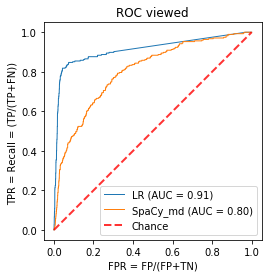

In [229]:
plot_roc_mat(Y_valid,res)

### Load model

In [319]:
output_dir='test'
print("Loading from", output_dir)
nlp2 = spacy.load(output_dir)


Loading from test
We are starving and we need urgently food: water, bread, milk {'POSITIVE': 0.8373962044715881, 'NEGATIVE': 0.16260382533073425}


In [329]:
test_text = "I am going to the concert of U2 in Zurich tomorrow"
doc = nlp2(test_text)
print(test_text, doc.cats)

I am going to the concert of U2 in Zurich tomorrow {'POSITIVE': 0.00011521164560690522, 'NEGATIVE': 0.9998847246170044}


In [326]:
test_set =X_test.to_list()
y_prob=[]

for n in range(0,len(test_set)):
    test = nlp2(test_set[n])
    y_prob.append( test.cats['POSITIVE']  )
    



In [330]:
y_prob=np.array(y_prob)
y_pred=y_prob>.5

print(classification_report(Y_test.values, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95      3732
           1       0.64      0.58      0.61       478

    accuracy                           0.91      4210
   macro avg       0.79      0.77      0.78      4210
weighted avg       0.91      0.91      0.91      4210



In [331]:
print(confusion_matrix(Y_test,y_pred))

[[3574  158]
 [ 201  277]]
